In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install noisereduce

In [3]:
import os
import pandas as pd
import numpy as np
import soundfile as sf
import noisereduce as nr
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from tqdm import tqdm
import random
import shutil
from IPython.display import Audio
from librosa.display import specshow
from librosa.display import waveshow
import uuid

In [4]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/AICOSS/Tasmanian_Birdsong"
AUDIO_DIR = os.path.join(BASE_DIR, "audio")
ANNOTATION_PATH = os.path.join(BASE_DIR, "annotations.csv")
AUG_DIR = os.path.join(BASE_DIR, "augmented_audio")

PREPROCESSED_DIR = os.path.join(BASE_DIR, "preprocessed_audio")
CLEANED_PATH = os.path.join(BASE_DIR, "cleaned.csv")

df = pd.read_csv(ANNOTATION_PATH)

In [5]:
df.head()

,sample,species,call_type,start,end
0,BD060A_CH01_20240328_220014_16kHz_290_320.wav,Masked Owl,screech,9.00,12.36
1,BD060A_CH01_20240331_210000_16kHz_660_690.wav,Masked Owl,screech,19.96,23.96
2,BD060A_CH01_20240331_210000_16kHz_1020_1050.wav,Masked Owl,screech,16.06,18.13
3,CH07_20240703_180000_16kHz_1380_1410.wav,Masked Owl,screech,23.12,25.19
4,CH07_20240703_180000_16kHz_1810_1840.wav,Masked Owl,screech,18.65,20.72


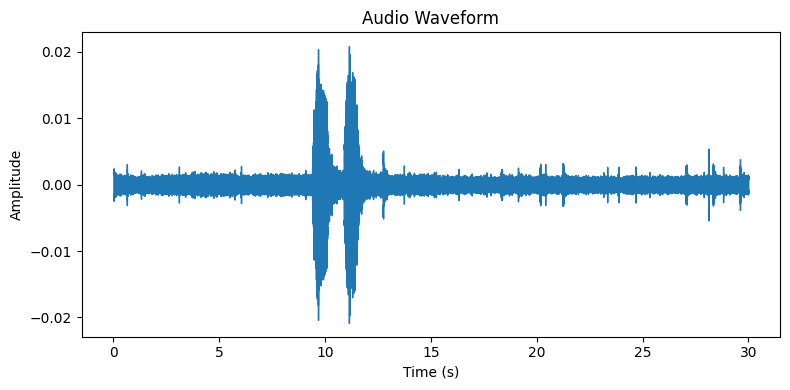

In [6]:
y, sr = librosa.load(AUDIO_DIR + '/' + df['sample'][0], sr=16000)

plt.figure(figsize=(8, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

audio = Audio(y, rate=sr)
display(audio)

In [7]:
unique_samples = df['sample'].nunique()
total_samples = len(df)

print(f"총 row 수: {total_samples}")
print(f"고유한 sample 수: {unique_samples}")
print(f"중복된 파일 수: {total_samples - unique_samples}")

총 row 수: 699
고유한 sample 수: 559
중복된 파일 수: 140


In [8]:
sample_count = {}
new_sample_names = []

for sample in df['sample']:
    if sample not in sample_count:
        sample_count[sample] = 0
        new_name = sample
    else:
        sample_count[sample] += 1
        name, ext = os.path.splitext(sample)
        new_name = f"{name}({sample_count[sample]}){ext}"
    new_sample_names.append(new_name)
    src_path = os.path.join(AUDIO_DIR, sample)
    dst_path = os.path.join(AUDIO_DIR, new_name)
    if os.path.exists(src_path) and not os.path.exists(dst_path):
        shutil.copyfile(src_path, dst_path)

df['sample'] = new_sample_names
df.to_csv(CLEANED_PATH, index=False)

In [9]:
unique_samples = df['sample'].nunique()
total_samples = len(df)

print("[중복제거 후]")
print(f"총 row 수: {total_samples}")
print(f"고유한 sample 수: {unique_samples}")
print(f"중복된 파일 수: {total_samples - unique_samples}")

[중복제거 후]
총 row 수: 699
고유한 sample 수: 699
중복된 파일 수: 0


Total sample count: 699


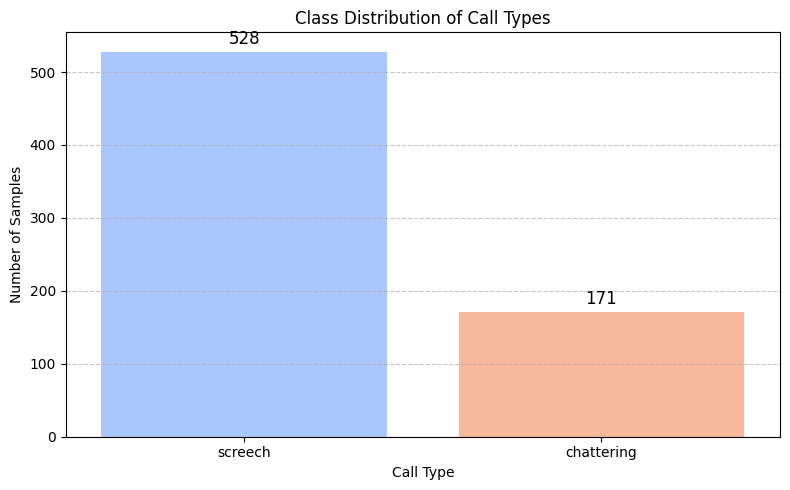

Class Imbalance Ratio: 3.09
Majority Class: screech (Count: 528)
Minority Class: chattering (Count: 171)


In [10]:
print(f"Total sample count: {len(df)}")

label_counts = df['call_type'].value_counts()
majority_class = label_counts.idxmax()
minority_class = label_counts.idxmin()
majority_count = label_counts.max()
minority_count = label_counts.min()
imbalance_ratio = majority_count / minority_count

plt.figure(figsize=(8, 5))
colors = sns.color_palette("coolwarm", n_colors=len(label_counts))
label_counts.plot(kind='bar', color=colors)
bars = plt.bar(label_counts.index, label_counts.values, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

plt.title('Class Distribution of Call Types')
plt.ylabel('Number of Samples')
plt.xlabel('Call Type')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}")
print(f"Majority Class: {majority_class} (Count: {majority_count})")
print(f"Minority Class: {minority_class} (Count: {minority_count})")

In [11]:
def preprocess():
    for i, row in tqdm(df.iterrows(), total=len(df)):
        filepath = os.path.join(AUDIO_DIR, row['sample'])
        try:
            y, sr = librosa.load(filepath, sr=None)

            start_sample = int(row['start'] * sr)
            end_sample = int(row['end'] * sr)
            y_trimmed = y[start_sample:end_sample]

            y_denoised = nr.reduce_noise(y=y_trimmed, sr=sr)

            y_norm = librosa.util.normalize(y_denoised)

            out_path = os.path.join(PREPROCESSED_DIR, row['sample'])
            sf.write(out_path, y_norm, sr)

        except Exception as e:
            print(f"Error processing {filepath}: {e}")

In [12]:
def augmentation():
    print("Augmentation 시작...")

    target_counts = {
        'screech': 528,
        'chattering': 773
    }

    for call_type, target in target_counts.items():
        df_subset = df[df['call_type'] == call_type].sample(n=target, replace=True, random_state=42)

        for i, row in tqdm(df_subset.iterrows(), total=target, desc=f"{call_type} augmenting"):
            filepath = os.path.join(PREPROCESSED_DIR, row['sample'])
            try:
                y, sr = librosa.load(filepath, sr=None)
                method = random.choice(['pitch', 'noise', 'stretch'])

                if method == 'pitch':
                    y_aug = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=random.choice([-2, -1, 1, 2]))
                    suffix = '_pitch'

                elif method == 'noise':
                    noise = np.random.normal(0, 0.005, size=y.shape)
                    y_aug = y + noise
                    suffix = '_noise'

                elif method == 'stretch':
                    rate = random.uniform(0.8, 1.2)
                    D = librosa.stft(y)
                    D_stretch = librosa.phase_vocoder(D, rate=rate)
                    y_aug = librosa.istft(D_stretch)
                    y_aug = librosa.util.fix_length(y_aug, size=len(y))
                    suffix = '_stretch'

                new_filename = row['sample'].replace(".wav", f"{suffix}_{uuid.uuid4().hex[:8]}.wav")
                sf.write(os.path.join(AUG_DIR, new_filename), y_aug, sr)

            except Exception as e:
                print(f"[!] Error augmenting {filepath}: {e}")

    print("\nAugmentation 완료\n")


In [13]:
#os.makedirs(AUG_DIR, exist_ok=True)
#os.makedirs(PREPROCESSED_DIR, exist_ok=True)

#preprocess()
#augmentation()

100%|██████████| 699/699 [01:12<00:00,  9.70it/s]


Augmentation 시작...


chattering augmenting: 100%|██████████| 773/773 [00:33<00:00, 23.12it/s]


Augmentation 완료



In [14]:
import glob

def create_augmented_dataframe(df_original):
    augmented_rows = []

    for _, row in df_original.iterrows():
        original_name = row['sample']
        base_name = original_name.replace(".wav", "")

        for suffix in ['_pitch', '_noise', '_stretch']:
            pattern = os.path.join(AUG_DIR, f"{base_name}{suffix}_*.wav")
            matches = glob.glob(pattern)

            for aug_path in matches:
                aug_name = os.path.basename(aug_path)
                new_row = row.copy()
                new_row['sample'] = aug_name
                new_row['aug_method'] = suffix.strip('_')
                augmented_rows.append(new_row)

    df_aug = pd.DataFrame(augmented_rows)
    return df_aug


In [15]:
df_aug = create_augmented_dataframe(df)
print(f"증강된 샘플 수: {len(df_aug)}")
df_aug.head()

증강된 샘플 수: 1301


,sample,species,call_type,start,end,aug_method
0,BD060A_CH01_20240328_220014_16kHz_290_320_pitc...,Masked Owl,screech,9.00,12.36,pitch
1,BD060A_CH01_20240331_210000_16kHz_660_690_stre...,Masked Owl,screech,19.96,23.96,stretch
1,BD060A_CH01_20240331_210000_16kHz_660_690_stre...,Masked Owl,screech,19.96,23.96,stretch
1,BD060A_CH01_20240331_210000_16kHz_660_690_stre...,Masked Owl,screech,19.96,23.96,stretch
4,CH07_20240703_180000_16kHz_1810_1840_pitch_22e...,Masked Owl,screech,18.65,20.72,pitch


In [16]:
df['aug_method'] = 'original'
df_all = pd.concat([df, df_aug], ignore_index=True)
df_all.to_csv(os.path.join(BASE_DIR, 'preprocessed.csv'), index=False)
df_all.head()

,sample,species,call_type,start,end,aug_method
0,BD060A_CH01_20240328_220014_16kHz_290_320.wav,Masked Owl,screech,9.00,12.36,original
1,BD060A_CH01_20240331_210000_16kHz_660_690.wav,Masked Owl,screech,19.96,23.96,original
2,BD060A_CH01_20240331_210000_16kHz_1020_1050.wav,Masked Owl,screech,16.06,18.13,original
3,CH07_20240703_180000_16kHz_1380_1410.wav,Masked Owl,screech,23.12,25.19,original
4,CH07_20240703_180000_16kHz_1810_1840.wav,Masked Owl,screech,18.65,20.72,original


Total sample count: 2000


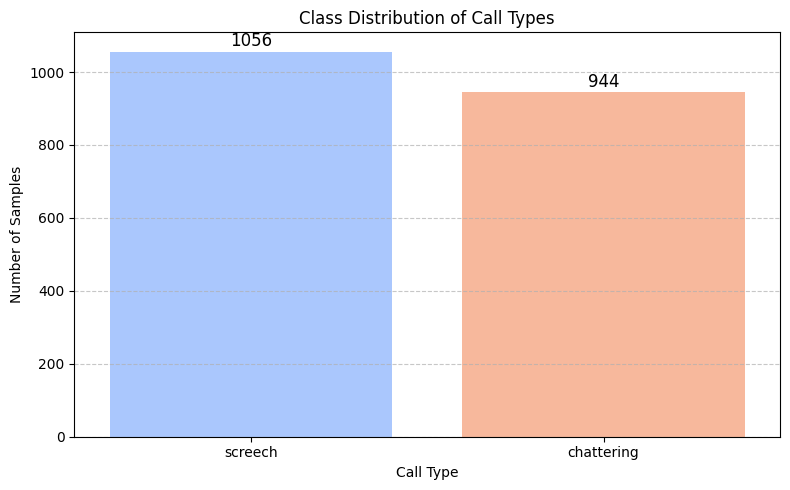

[After preprocessing]

Class Imbalance Ratio: 1.12
Majority Class: screech (Count: 1056)
Minority Class: chattering (Count: 944)


In [17]:
print(f"Total sample count: {len(df_all)}")

label_counts = df_all['call_type'].value_counts()
majority_class = label_counts.idxmax()
minority_class = label_counts.idxmin()
majority_count = label_counts.max()
minority_count = label_counts.min()
imbalance_ratio = majority_count / minority_count

plt.figure(figsize=(8, 5))
colors = sns.color_palette("coolwarm", n_colors=len(label_counts))
label_counts.plot(kind='bar', color=colors)
bars = plt.bar(label_counts.index, label_counts.values, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

plt.title('Class Distribution of Call Types')
plt.ylabel('Number of Samples')
plt.xlabel('Call Type')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("[After preprocessing]\n")
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}")
print(f"Majority Class: {majority_class} (Count: {majority_count})")
print(f"Minority Class: {minority_class} (Count: {minority_count})")

In [19]:
df_all.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sample      2000 non-null   object 
 1   species     2000 non-null   object 
 2   call_type   2000 non-null   object 
 3   start       2000 non-null   float64
 4   end         2000 non-null   float64
 5   aug_method  2000 non-null   object 
dtypes: float64(2), object(4)
memory usage: 93.9+ KB


,start,end
count,699.000000,699.000000
mean,13.888155,16.878541
std,7.866175,7.859661
min,0.020000,1.750000
25%,7.255000,10.155000
50%,14.180000,17.310000
75%,20.525000,23.650000
max,29.120000,33.790000


In [20]:
print("call_type 분포:")
print(df_all['call_type'].value_counts())

print("\n증강 방법 분포:")
print(df_all['aug_method'].value_counts(dropna=False))

call_type 분포:
call_type
screech       1056
chattering     944
Name: count, dtype: int64

증강 방법 분포:
aug_method
original    699
pitch       447
noise       437
stretch     417
Name: count, dtype: int64


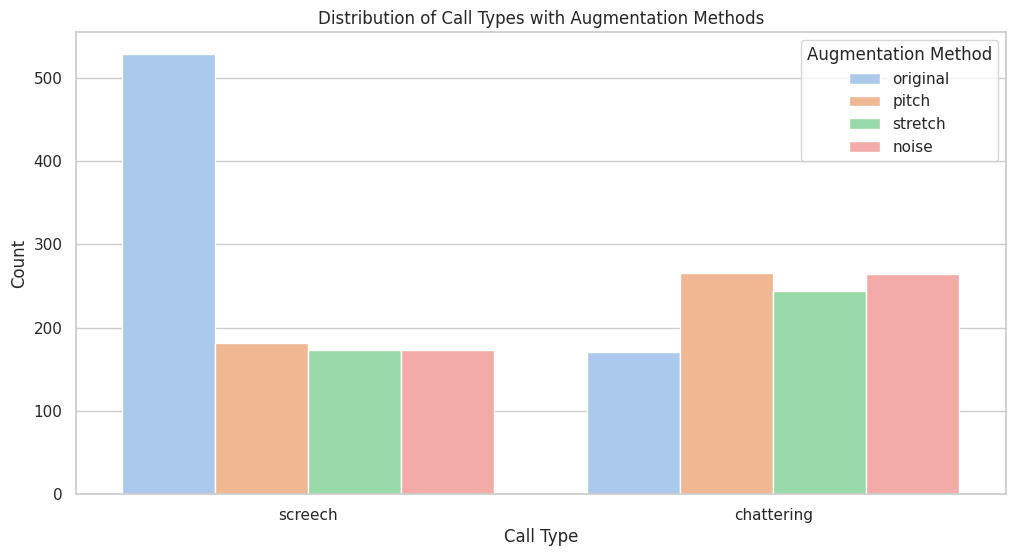

In [22]:
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(12, 6))
sns.countplot(data=df_all, x='call_type', hue='aug_method')
plt.title("Distribution of Call Types with Augmentation Methods")
plt.xlabel("Call Type")
plt.ylabel("Count")
plt.legend(title="Augmentation Method")
plt.show()